***Laue Pattern peak search on a large set of binary Images using multiprocessing***

on jupyter-slurm.esrf.fr

or

locally on desktop computer (with some cpus) and with access to the LaueTools environment or folder

**This Notebook is a part of the LaueTools Package** 
Author: J.-S. Micha

Last Revision:   March 2025

tested with python3

**Objectives**

- Load and display Laue pattern images
- Perform a Peak Search, display found peaks
- Perform a Peak Search on several images with several cpus

# imports

**check number of available cores**

In [1]:
import multiprocessing
nb_cpus = multiprocessing.cpu_count()
print(f"There are {nb_cpus} cores available - setting the variable nb_cpus to use them all ")

There are 64 cores available - setting the variable nb_cpus to use them all 


In [2]:
# if looged in jupyter-slurm.esrf.fr, please select the kernel LAUETOOLSENV2
# in Kernel top bar menu  /Kernel/ change Kernel

In [3]:
# use Lauetools installed in an environnement (with pip or conda) is recommended
import os, sys
import LaueTools as LT
LaueToolsCode_Folder = os.path.split(LT.__file__)[0]
print('absolute path of LaueTools package',LaueToolsCode_Folder)
print("\nIf you are on jupyter-slurm, you should see: <module 'LaueTools' from '.../.../bm32/inhouse/lauetoolsenv2/lib/python3.8/site-packages/LaueTools/__init__.py'>")
LT


absolute path of LaueTools package /mnt/multipath-shares/data/bm32/inhouse/lauetoolsenv2/lib/python3.8/site-packages/LaueTools

If you are on jupyter-slurm, you should see: <module 'LaueTools' from '.../.../bm32/inhouse/lauetoolsenv2/lib/python3.8/site-packages/LaueTools/__init__.py'>


<module 'LaueTools' from '/mnt/multipath-shares/data/bm32/inhouse/lauetoolsenv2/lib/python3.8/site-packages/LaueTools/__init__.py'>

In [4]:
#OR use your own lauetools.
# Setting absolute path to LaueTools Modules if Lauetools has not been installed with pip
if 0:
    LaueToolsCode_Folder = '/my/path/to/lauetools/'
    import sys
    sys.path.append(LaueToolsCode_Folder)
    print(sys.path)

In [5]:
# for jupyter lab
#%matplotlib inline

# for jupyter hub
%matplotlib notebook 

import time,copy,os

# Third party modules
import matplotlib as mpl     # graphs and plots
import matplotlib.pyplot as plt
import numpy as np    # numerical arrays
import fabio
from matplotlib.patches import Ellipse

# LaueTools modules
from LaueTools import IOLaueTools as IOLT   # read and write ASCII file  (IO) 
from LaueTools import readmccd as RMCCD       # read CCD and detector binary file, PeakSearch methods
from LaueTools import lauecore as LAUE       
from LaueTools import CrystalParameters as CP       
from LaueTools import generaltools as GT
from LaueTools import LaueGeometry as LaueGeo
from LaueTools import dict_LaueTools as DictLT
from LaueTools import imageprocessing as ImProc
# matplotlib preferences
plt.style.use('classic')
mpl.rcParams['image.cmap'] = 'inferno'
mpl.rcParams['figure.facecolor'] = 'none'
mpl.rcParams['font.size'] = 8

-- warning: Missing library libtiff, Please install: pylibtiff if you need open some tiff images. However, Fabio or PIL can do the job!


# set user data filename & folders, detector type

images can be located in folders located in 2 different cases

CASE 1: set folder containing binary images located at ESRF, in /DATA/VISITOR or /DATA/BM32/INHOUSE, or /DATA/PROJECTS/

In [6]:
from pathlib import Path
if 1:
    maindatafolder = '/data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA'
    subfolderscandata = 'sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001'
    imagefolder = Path(maindatafolder+'/'+subfolderscandata)
    
    # calibration parameters file
    detfile = Path(maindatafolder+'/'+'sample1_test/sample1_test_Ge_20240628/scan0001/Ge111calib_28june2024.det')
    datfilefolder = Path(maindatafolder+'/'+subfolderscandata+'//'+'datfiles_notebook')
    
    if not datfilefolder.exists():
        print('Creating "datfilefolder" ...')
        Path.mkdir(datfilefolder)
    
    #outputfolder = '/data/visitor/blc14894/bm32/20231007/NOBACKUP/'
    
    prefixfilename= 'img_'
    suffix='.tif'
    CCDLabel = 'sCMOS'
    
    #sizeofzeropadding = 5    # example: image_00123.tif
    #sizeofzeropadding = 0    # example: image_123.tif
    sizeofzeropadding = 4
    
    print('images folder:  \n    =====> %s'%imagefolder)
    print('peaks list .dat files will be written in this folder: \n    =====> %s'%datfilefolder)

images folder:  
    =====> /data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA/sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001
peaks list .dat files will be written in this folder: 
    =====> /data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA/sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001/datfiles_notebook


CASE 2: set folder containing binary images in LOCAL FOLDERS

In [7]:
if 0:
    imagefolder = '/home/micha/LaueProjects/Guinebretiere_Feb21/Diamond/'
    datfilefolder = '/home/micha/LaueProjects/Guinebretiere_Feb21/Diamond/datfiles'
    print('images folder:',imagefolder)
    prefixfilename= 'Gediam_'
    suffix='.tif'
    #sizeofzeropadding = 5    # image_00123.tif
    #sizeofzeropadding = 0    # image_123.tif
    sizeofzeropadding = 4
    
    print('images folder:',imagefolder)
    print('.dat files will be written in this folder: ', datfilefolder)


# test read image and peaksearch on 1 image

**select 1 image file by `imageindex`**
(splitting imagefilename allows loop over images:  prefix+index.extension)

In [8]:
imageindex=600

#-----------------------------------------------------------
paddedindex = '%s'%str(imageindex).zfill(sizeofzeropadding)
imagefilename = f"{prefixfilename}{paddedindex}{suffix}"

if not Path(imagefolder).exists():
    print('"imagefolder" does not exists!')
    
elif not (Path(imagefolder)/imagefilename).exists():
    print('this is image does not exist. Check imageindex and/or imagefolder')
else:
    print("imagefilename :",imagefilename)

imagefilename : img_0600.tif


**read image file and get data**



imagefilename : img_0600.tif


<IPython.core.display.Javascript object>


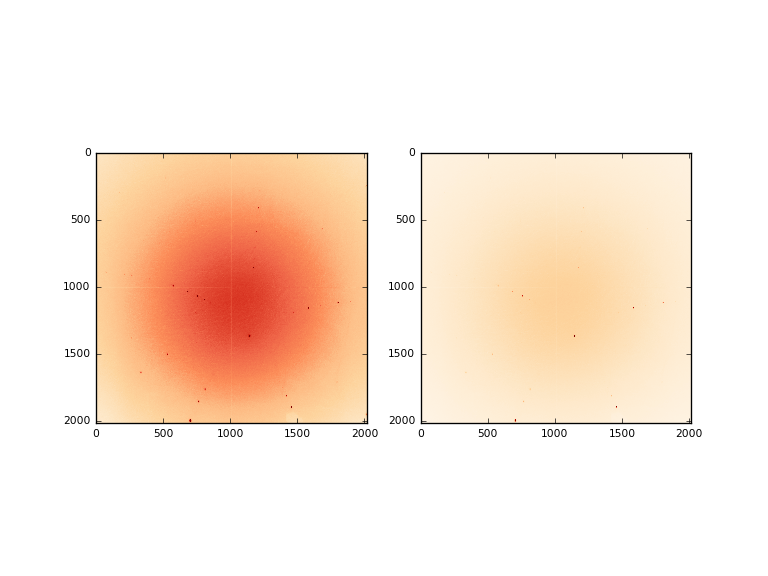

In [9]:
print("imagefilename :",imagefilename)
im = fabio.open(Path(imagefolder)/imagefilename)
fig, ax = plt.subplots(ncols=2)
ax[0].imshow(np.log10(im.data),vmin=3,vmax=3.5,cmap=plt.cm.OrRd)  # cmap=plt.cm.inferno)
ax[1].imshow(im.data,vmin=1000,vmax=6000
             ,cmap=plt.cm.OrRd)

***peaksearch*** performed on modified image 'newdataimage' (by default this is done on image given as first argument). Peaksearch results can purged from peaks already present in file as an optional argument Remove_BlackListedPeaks_fromfile.

In [10]:
imageindex = 600
paddedindex = '%s'%str(imageindex).zfill(sizeofzeropadding)
imagefilename = f"{prefixfilename}{paddedindex}{suffix}"
fullpathimagefile = Path(imagefolder)/imagefilename
print(fullpathimagefile)
#imagefilename = composite_image_filename
#imagefilename =filtered_image_filename

ti1= time.time()

#blacklistedpeaksfile=os.path.join(folder,'Blacklist.dat')
blacklistedpeaksfile = None
"""
RMCCD.PeakSearch(
    fullpathimagefile,
    CCDLabel='sCMOS',
    center=None,
    boxsizeROI=(200, 200),
    PixelNearRadius=5,
    removeedge=2,
    IntensityThreshold=400,
    thresholdConvolve=200,
    paramsHat=(4, 5, 2),
    boxsize=15,
    verbose=0,
    position_definition=1,
    local_maxima_search_method=1,
    peakposition_definition='max',
    fit_peaks_gaussian=1,
    xtol=1e-05,
    return_histo=0,
    FitPixelDev=25,
    write_execution_time=1,
    Saturation_value=65535,
    Saturation_value_flatpeak=65535,
    MinIntensity=0,
    PeakSizeRange=(0, 200),
    Data_for_localMaxima=None,
    Fit_with_Data_for_localMaxima=False,
    Remove_BlackListedPeaks_fromfile=None,
    maxPixelDistanceRejection=15.0,
    NumberMaxofFits=5000,
    reject_negative_baseline=True,
    formulaexpression='A-1.1*B',
    listrois=None,
)
"""

"""
[PeakSearch]
intensitythreshold = 1030
pixelnearradius = 3
boxsize = 3
xtol = 0.001
fitpixeldev = 6.0
maxintensity = 65534.0
minintensity = 0.0
maxpeaksize = 3.0
minpeaksize = 0.65
fit_peaks_gaussian = 1
local_maxima_search_method = 0
position_definition = 1
"""
Data_for_localMaxima = 'auto_background'
IntensityThreshold = 200

res=RMCCD.PeakSearch(filename = os.path.join(imagefolder,imagefilename),
                    return_histo=0,
                    local_maxima_search_method=0,
                    CCDLabel=CCDLabel,
                    IntensityThreshold=IntensityThreshold,
                    boxsize=3,
                    fit_peaks_gaussian=1,
                    xtol=0.001,
                    FitPixelDev=6,
                    Data_for_localMaxima=Data_for_localMaxima,#newdataimage
                    center=None,
                    boxsizeROI=(200, 200),
                    PixelNearRadius=3,
                    removeedge=2,
                    thresholdConvolve=200,
                    paramsHat=(4, 5, 2),
                    verbose=0,
                    position_definition=1,
                    peakposition_definition='max',
                    write_execution_time=1,
                    Saturation_value=65535,
                    Saturation_value_flatpeak=65535,
                    MinIntensity=0,
                    PeakSizeRange=(0.1, 3),
                    Fit_with_Data_for_localMaxima=False,
                    Remove_BlackListedPeaks_fromfile=None,
                    maxPixelDistanceRejection=15.0,
                    NumberMaxofFits=5000,
                    reject_negative_baseline=True,
                    formulaexpression='A-1.1*B',
                    listrois=None
                    )
tps =time.time()
print("peak search time",tps-ti1)
nbpeaks = len(res[0])
print(f"{nbpeaks} peaks  are found!")

/data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA/sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001/img_0600.tif
peak search time 0.579902172088623
102 peaks  are found!


## peaks positions in pixel units
unpack results as laue spots properties

In [11]:
peaklist=res[0]
print("nb of peaks in image",len(peaklist))
#peaklist[:,:2]
peak_X = peaklist[:,0]
peak_Y = peaklist[:,1]
peak_Isub = peaklist[:,2]
peak_fwaxmaj = peaklist[:,3]
peak_fwaxmin = peaklist[:,4]
peak_inclination = peaklist[:,5]
Xdev = peaklist[:,6]
Ydev = peaklist[:,7]
peak_bkg = peaklist[:,8]
Ipixmax = peaklist[:,9]
peak_Itot = peak_Isub + peak_bkg

nb of peaks in image 102


***plot the results   with zoom on the 100 first most intense peaks***

<IPython.core.display.Javascript object>


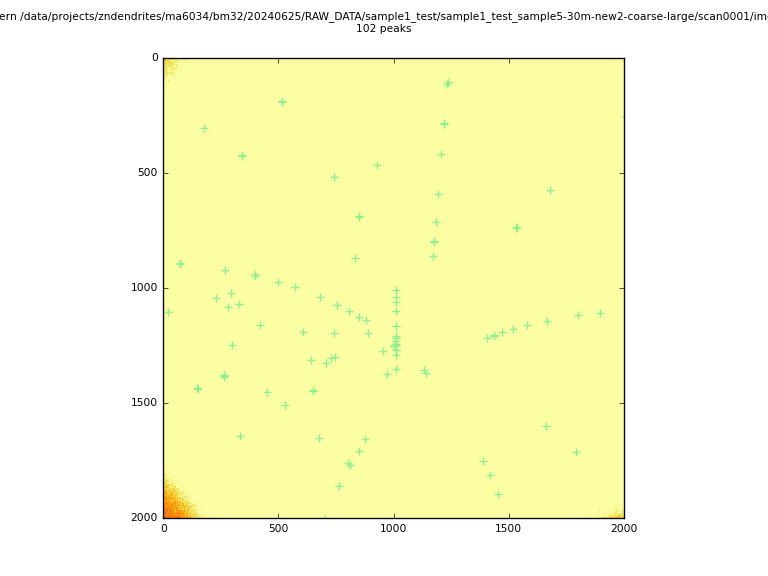

<IPython.core.display.Javascript object>


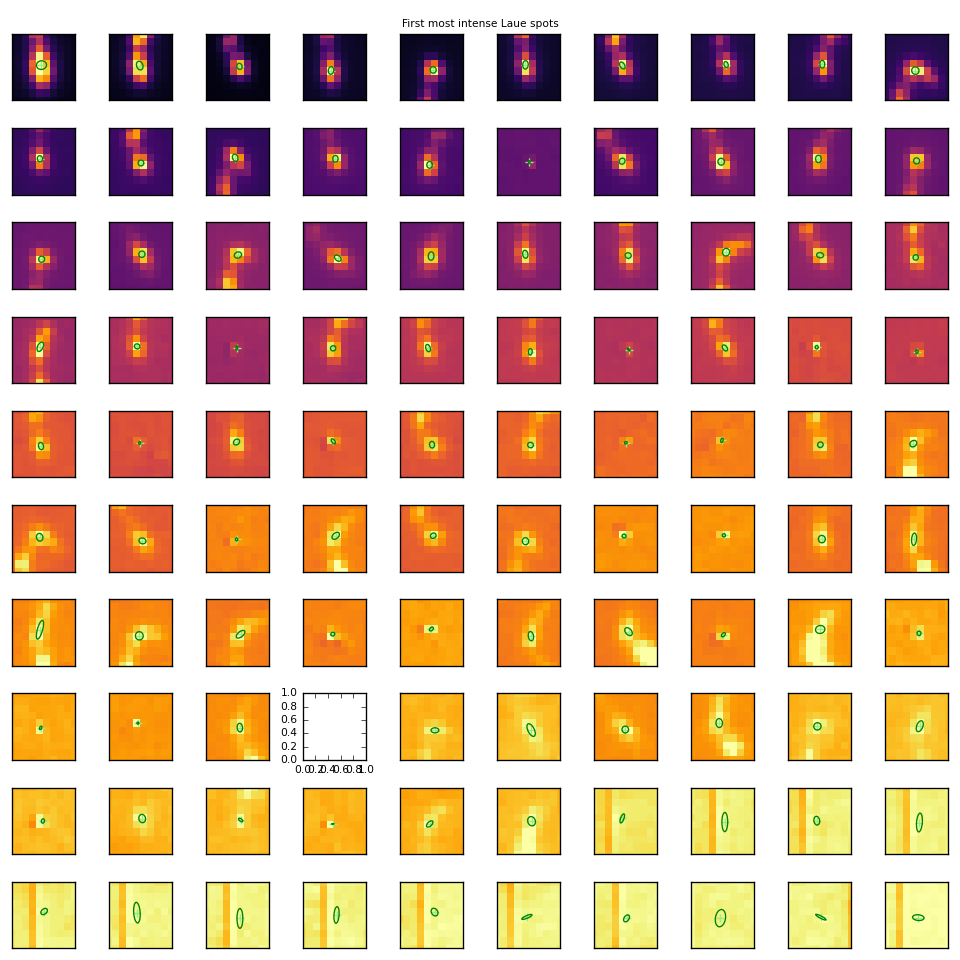

Dimensions of C (10, 9) should be one smaller than X(11) and Y(11) while using shading='flat' see help(pcolormesh)


In [12]:
fig0, ax0 = plt.subplots()

ax0.imshow(im.data,interpolation='nearest',vmin=1000,vmax=1200,cmap=plt.cm.inferno)
ax0.scatter(peak_X-1,peak_Y-1,marker='+',color='lightgreen',s=30)
ax0.set_xlim((0,2000))
ax0.set_ylim((2000,0))

fig0.suptitle('Laue pattern %s\n%d peaks'%(fullpathimagefile,len(peaklist)))

npeaks = len(peak_X)
sqrt_nvignette = min(10,int(np.ceil(np.sqrt(npeaks))))
fig = plt.figure(figsize=(sqrt_nvignette,sqrt_nvignette), )
fig.suptitle('First most intense Laue spots')
for iii in np.arange(min(npeaks,100)):
    try:
        ax = fig.add_subplot(sqrt_nvignette,sqrt_nvignette,iii+1)
        x,y = peak_X[iii]-1,peak_Y[iii]-1
        size = max(np.abs(peak_fwaxmaj[iii]),np.abs(peak_fwaxmin[iii]),3)
        intensity = peak_Itot[iii]
        xmin,xmax = int(np.round(x-1.5*size)),int(np.round(x+1.5*size))+1
        ymin,ymax = int(np.round(y-1.5*size)),int(np.round(y+1.5*size))+1
        ax.pcolormesh(np.arange(xmin-.5,xmax+.5), np.arange(ymin-.5, ymax+.5), 
                      im.data[ymin:ymax,xmin:xmax], 
                      vmin=0,vmax=intensity,cmap=plt.cm.inferno)
        ax.scatter(x,y,marker='+',color='lightgreen',s=30,label='fitted') # fitted
        e = Ellipse(xy=(x,y),
            width=peak_fwaxmaj[iii],
            height=peak_fwaxmin[iii],
            angle=peak_inclination[iii]+90)
        ax.add_artist(e)
        e.set_edgecolor('green')
        e.set_facecolor('none')
        ax.set_xlim(xmin,xmax-1)
        ax.set_ylim(ymax-1,ymin)
        ax.set_xticks([])
        ax.set_yticks([]) 
        #if iii == min(npeaks,100)-1:
    except Exception as e:
        print(e)
        pass
    #    plt.legend()

fig.tight_layout()
plt.show()


if you feel you can get more peaks from the image, you may decide to reduce `IntensityThreshold` in the `PeakSearch` function above

In [13]:
MASK_REGION = True


def deletepeaks(peaklist, boxparams):
    """delete rows of peaklist array where first 2 components satisfy the box condition
    |X-Xcenter|<halfwidth & |Y-Ycenter|<halfheight 
    
    where Xcenter, Ycenter, halfwidth, halfheight = boxparams
    
    return a modified copy of peaklist"""
    
    Xcenter, Ycenter, halfwidth, halfheight = boxparams
    X,Y = peaklist[:,:2].T
    ## some peaks removal according to X, Y
    condX = np.fabs(X-Xcenter)<halfwidth
    condY = np.fabs(Y-Ycenter)<halfheight
    cond = np.logical_and(condX, condY)
    filteredpeaklist =  np.delete(peaklist, np.where(cond)[0], axis=0)
    return filteredpeaklist

#Xcenter, Ycenter, halfwidth, halfheight 
boxparams = 1009,1000,7,1100
if MASK_REGION:
    peaklist = deletepeaks(peaklist, boxparams)

## write the output: peak list  in .dat file

In [14]:
# to add a string in the output file name
AddedString = 'Notebook_'

outputpeaklistprefix = prefixfilename+AddedString+str(imageindex).zfill(sizeofzeropadding)

print('peaklist.shape  (nb spots, nb properties)       :\n',peaklist.shape)
print("fullpathimagefile      :\n =====>",fullpathimagefile)
print('outputpeaklistprefix   :\n =====>', outputpeaklistprefix)

fullpath_datfile= RMCCD.writepeaklist(peaklist,outputpeaklistprefix,
                                      outputfolder=datfilefolder,
                                      initialfilename=fullpathimagefile)
datfilename = fullpath_datfile
print('Peaklist in datfilename     :\n =====>',datfilename)

peaklist.shape  (nb spots, nb properties)       :
 (87, 10)
fullpathimagefile      :
 =====> /data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA/sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001/img_0600.tif
outputpeaklistprefix   :
 =====> img_Notebook_0600
Peaklist in datfilename     :
 =====> /data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA/sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001/datfiles_notebook/img_Notebook_0600.dat


## read calibration .det file and set `dictcalibparams`

and build hence a .cor file (containing Laue spots porperties : X, Y, I  + 2$\theta$, $\chi$ scttering angles)

In [15]:
try:
    dictcalibparams = None
    #dictcalibparams = IOLT.readCalib_det_file('/data/bm32/inhouse/LAUE/Test02Sep20_LAUE/Jeudi/calibSilukas.det')
    dictcalibparams = IOLT.readCalib_det_file(detfile)
except NameError:
    print('please provide the path to a .det file')

# write . cor if calibration parameters are known
if dictcalibparams is not None:# 
    if isinstance(dictcalibparams, dict):

        datfolder, datfile = os.path.split(fullpath_datfile)

        LaueGeo.convert2corfile(datfile,
                    [],  # should be useless and pixelsize argument is also missing...
                    dirname_in=datfolder,
                    dirname_out=datfolder,
                    CCDCalibdict=dictcalibparams,
                    add_props=True)

# CASE 1: peaksearch on several images

(re)use a .psp file (generated automatically by LaueTools GUI)

CASE 1: use of psp.file

In [16]:
#first we read the file search parameters .psp (or we manually set the params afterwards)
filepsp = os.path.join(imagefolder,'PeakSearch_img_0840_LT_2.psp')

dictPeakSearch = RMCCD.readPeakSearchConfigFile(filepsp)
dictPeakSearch["Data_for_localMaxima"] = 'auto_background'
dictPeakSearch["formulaexpression"] = 'A-1.1*B'
dictPeakSearch["Remove_BlackListedPeaks_fromfile"] = None
dictPeakSearch["listrois"] = None

# some corrections
dictPeakSearch['IntensityThreshold']=200
dictPeakSearch['boxsize']=5

print(dictPeakSearch)

{'IntensityThreshold': 200, 'PixelNearRadius': 10, 'boxsize': 5, 'xtol': 0.001, 'FitPixelDev': 6.0, 'MaxPeakSize': 3.0, 'MinPeakSize': 0.65, 'fit_peaks_gaussian': 1, 'local_maxima_search_method': 0, 'position_definition': 1, 'Data_for_localMaxima': 'auto_background', 'formulaexpression': 'A-1.1*B', 'Remove_BlackListedPeaks_fromfile': None, 'listrois': None}


In [17]:
# apply these parameters to all images
# range of image indices
first_image, last_image = 0, 1680
addedprefixstring = 'from_nb_'

nbcpus = 64

#********************************

ti1= time.time()
RMCCD.peaksearch_multiprocessing(fileindexrange = (first_image, last_image),
                           filenameprefix = prefixfilename, 
                           suffix=".tif", 
                           nbdigits=sizeofzeropadding,
                           dirname_in=imagefolder,
                           outputname=f"{prefixfilename}{addedprefixstring}",
                           dirname_out=datfolder,
                           CCDLABEL="sCMOS",
                           KF_DIRECTION="Z>0",
                           dictPeakSearch=dictPeakSearch,
                           nb_of_cpu=nbcpus,
                                verbose=1)#,
                           #nbdigits_out=5)
tps = time.time()
totaltime = tps-ti1
nbimages = last_image+1-first_image
nbimagespersecond = (nbimages)/(totaltime)
print(f"For {nbcpus} cpus and {nbimages} images")
print(f"Total peak search time = {totaltime:0.2f} sec , nb images/sec = {nbimagespersecond:0.2f}")

using 64 cpu(s)
dispatch of fileindex  [[0, 25], [26, 51], [52, 77], [78, 103], [104, 129], [130, 155], [156, 181], [182, 207], [208, 233], [234, 259], [260, 285], [286, 311], [312, 337], [338, 363], [364, 389], [390, 415], [416, 441], [442, 467], [468, 493], [494, 519], [520, 545], [546, 571], [572, 597], [598, 623], [624, 649], [650, 675], [676, 701], [702, 727], [728, 753], [754, 779], [780, 805], [806, 831], [832, 857], [858, 883], [884, 909], [910, 935], [936, 961], [962, 987], [988, 1013], [1014, 1039], [1040, 1065], [1066, 1091], [1092, 1117], [1118, 1143], [1144, 1169], [1170, 1195], [1196, 1221], [1222, 1247], [1248, 1273], [1274, 1299], [1300, 1325], [1326, 1351], [1352, 1377], [1378, 1403], [1404, 1429], [1430, 1455], [1456, 1481], [1482, 1507], [1508, 1533], [1534, 1559], [1560, 1585], [1586, 1611], [1612, 1637], [1638, 1680]]
Execution time : 15.90 sec
all 1681 images contain at least one peak
For 64 cpus and 1681 images
Total peak search time = 15.97, nb images/sec = 105.

# CASE 2 (Recommended): PEAK SEARCH MULTIPROCESSING

CASE 2 (Recommended): PEAK SEARCH MULTIPROCESSING

- all peaks properties may also be stored in `allresults`
- .dat files results may be written in several folders
- masks may be applied

In [18]:
from tqdm import tqdm, tqdm_notebook

import multiprocessing
from multiprocessing import active_children, cpu_count

In [19]:
# global variable
addedstring = '' # 'nb_'  # string added to all .dat filename
CCDLabel = 'sCMOS'
formulaexpression = 'A-1.1*B'
MASK_REGION = True
#Xcenter, Ycenter, halfwidth, halfheight 
boxparams = 1009,1000,7,1100



# atomic function : peaksearch on a single image

# fine parameters of RMCCD.PeakSearch can be modified here
def peaksearch_oneimage(imageindex, prefix=prefixfilename,
                                      imagefolder=imagefolder,
                                      outputfolder=datfilefolder, sizeofzeropadding=sizeofzeropadding,
                                   IntensityThreshold=1200,
                           dictcalibparams =None,
                       verbose=0):
    """
    peaksearch on single image including auto background removal, fit local intensity array without background
    
    imageindex:   int, index of image in image filename (last digits before .extension)
    prefix: str, prefix of image filename. Should end with '_'
    imagefolder: str, absolute path to image files
    outputfolder: str, absolute path to peaks list files
    sizeofzeropadding: maximal number of digits for zero padding (usually 4)
    IntensityThreshold: int, minimum local peak amplitude"""
    
    
    
    paddedindex = '%s'%str(imageindex).zfill(sizeofzeropadding)
    imagefilename = f"{prefixfilename}{paddedindex}{suffix}"
    
    pathfile=os.path.join(imagefolder,imagefilename)
    try:
        with fabio.open(pathfile) as img:
            rawData = img.data

            framedim = rawData.shape

            # pythonic way to change immutable tuple...
            initframedim = list(DictLT.dict_CCD[CCDLabel][0])
            initframedim[0] = framedim[0]
            initframedim[1] = framedim[1]
            initframedim = tuple(initframedim)

            fliprot = 'no'
            #Data, framedim, fliprot

            #print('rawData',rawData.shape)

            backgroundimage = ImProc.compute_autobackground_image(rawData, boxsizefilter=10)
                # basic substraction
            usemask = True
            Data = ImProc.computefilteredimage(rawData, backgroundimage, CCDLabel, usemask=usemask,formulaexpression=formulaexpression)
        
    except FileNotFoundError:
        msg = "Sorry, the file "+ pathfile + " does not exist."
        if verbose> 0: print(msg) # Sorry, the file John.txt does not exist
        return [imageindex, []]
    
    
    Fit_with_Data_for_localMaxima=True # fit local intensity array without background

    res=RMCCD.PeakSearch(filename =None,
                        return_histo=0,
                        local_maxima_search_method=0,
                        CCDLabel=CCDLabel,
                        IntensityThreshold=IntensityThreshold,
                        boxsize=3,
                        fit_peaks_gaussian=1,
                        xtol=0.001,
                        FitPixelDev=6,
                        Data_for_localMaxima=Data,#newdataimage
                        center=None,
                        boxsizeROI=(200, 200),
                        PixelNearRadius=5,
                        removeedge=2,
                        thresholdConvolve=200,
                        paramsHat=(4, 5, 2),
                        verbose=verbose-1,
                        position_definition=1,
                        peakposition_definition='max',
                        write_execution_time=0,
                        Saturation_value=65535,
                        Saturation_value_flatpeak=65535,
                        MinIntensity=0,
                        PeakSizeRange=(0.65, 3),
                        Fit_with_Data_for_localMaxima=Fit_with_Data_for_localMaxima,
                        Remove_BlackListedPeaks_fromfile=None,
                        maxPixelDistanceRejection=10.0,
                        NumberMaxofFits=5000,
                        reject_negative_baseline=True,
                        formulaexpression='A-1.1*B',
                        listrois=None
                        )
    peaklist=res[0]
    if peaklist is not None:
        nbpeaks = len(peaklist)
        
    if peaklist is not None and MASK_REGION:
        peaklist = deletepeaks(peaklist, boxparams)

    outputpeaklistprefix = f"{prefixfilename}{addedstring}{paddedindex}"
    fullpathimagefile = os.path.join(imagefolder,imagefilename)

    fullpath_datfile= RMCCD.writepeaklist(peaklist,outputpeaklistprefix,outputfolder=outputfolder,
                                    initialfilename=fullpathimagefile, verbose=verbose-1)
    if fullpath_datfile is None:
        return [imageindex,0]+[]
    
    if verbose>0:  print('fullpath_datfile',fullpath_datfile)
#     print('len(peaklist)',len(peaklist))
    if dictcalibparams is not None:# write also .cor file
        if isinstance(dictcalibparams, dict):

            datfolder, datfile = os.path.split(fullpath_datfile)

            finalcorfilename = LaueGeo.convert2corfile(datfile,
                        [],  # should be useless and pixelsize argument is also missing...
                        dirname_in=datfolder,
                        dirname_out=datfolder,
                        CCDCalibdict=dictcalibparams,
                        add_props=True,
                        verbose=0)
            
            if verbose>0:  print('finalcorfilename',finalcorfilename)
            
    return [imageindex, nbpeaks]+peaklist.tolist()

In [21]:
# just to check some peak search
for kk in range(0,10):
    res = peaksearch_oneimage(kk, prefix=prefixfilename, imagefolder=imagefolder, outputfolder=datfilefolder,
                                  sizeofzeropadding=sizeofzeropadding,
                                   IntensityThreshold=200,
                                 dictcalibparams=dictcalibparams, verbose=0)
    print(f'kk = {kk}, found %d peaks'%res[1])

kk = 0, found 39 peaks
kk = 1, found 2 peaks
kk = 2, found 6 peaks
kk = 3, found 9 peaks
kk = 4, found 7 peaks
kk = 5, found 5 peaks


/mnt/multipath-shares/data/bm32/inhouse/lauetoolsenv2/lib/python3.8/site-packages/LaueTools/IOLaueTools.py:1028: UserWarning: Input line 2 contained no data and will not be counted towards `max_rows=2`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data_peak = np.loadtxt(filename_in, skiprows=SKIPROWS, max_rows=nbdatarows)


kk = 6, found 1 peaks
kk = 7, found 1 peaks
kk = 8, found 1 peaks
kk = 9, found 2 peaks


In [22]:
# uncomment to ignore warnings in the following
import warnings
warnings.filterwarnings('ignore')

In [23]:
if __name__=='__main__':
    import itertools

    #-----------------------------------------------------------------------
    firstimageindex, lastimageindex = 0, 1680
    listindinces = range(firstimageindex,lastimageindex+1)
    IntensityThreshold = 200
    
    outputfolder = datfilefolder
    
    BUILD_ALLRESULTS_LIST = True
    
    # it is advisable to have folder with a limited nb of files (chunk size = 5000)
    SPLITINTOSUBFOLDER = False
    nbfiles_per_folder = 5000
    subfolderprefix = 'datfiles_'
    #--------------------------------------------------------
    
    nbcpus= 64 # > 1 !!
    
    verboselevel = 0
    
    #----------------------------------------------------------------------
    if SPLITINTOSUBFOLDER:
        ll = np.array(listindinces)
        # create subfolders
        nbfolders = np.amax(ll//nbfiles_per_folder)+1
        for k in range(nbfolders):
            try:
                os.mkdir(os.path.join(outputfolder,subfolderprefix+'%d_%d'%(k*nbfiles_per_folder,
                                                                 (k+1)*nbfiles_per_folder-1)))
            except FileExistsError:
                continue
                
        # ugly way to prepare the list of outputfolder
        outputfolders = []
        for _idx in ll:
            subfolder_idx = _idx // nbfiles_per_folder 
            path_to_subfolder = os.path.join(outputfolder,
                                             subfolderprefix+'%d_%d'%(subfolder_idx*nbfiles_per_folder,
                                                                 (subfolder_idx+1)*nbfiles_per_folder-1))
            outputfolders.append(path_to_subfolder)
    else:
        outputfolders = itertools.repeat(outputfolder)
        
    #---------------------Multiprocessing-----------------------------------------------
    maxnbcpus = cpu_count()
    if nbcpus is None:
        nbcpus = maxnbcpus
    else:
        nbcpus = max(2,min(nbcpus,maxnbcpus))
    #print('nbcpus', nbcpus)
    
    nbimages = len(listindinces)
    #----------------------------------
        
    t00 = time.time()
    print(f'using peaksearch  on {nbimages} images, with {nbcpus} cpu(s)')

    
    args_peaksearch = zip(listindinces,
                   itertools.repeat(prefixfilename),
                   itertools.repeat(imagefolder),
                   outputfolders,
                  itertools.repeat(sizeofzeropadding),
                    itertools.repeat(IntensityThreshold),
                          itertools.repeat(dictcalibparams),
                          itertools.repeat(verboselevel)
                   )

    with multiprocessing.Pool(nbcpus) as pool:

        if BUILD_ALLRESULTS_LIST:
            allresults = pool.starmap(peaksearch_oneimage, tqdm(args_peaksearch, total=len(listindinces),
                                  desc='peak search progress bar:'), chunksize=1)
        else:
            pool.starmap(peaksearch_oneimage, tqdm(args_peaksearch, total=len(listindinces),
                                  desc='peak search progress bar:'), chunksize=1)

    elapsedtime=time.time()-t00
    children = active_children()
    print(f'total time is {elapsedtime:.3f} sec for {nbimages} images and {nbcpus} cpu(s)')
    print(f'Active children: {len(children)}')
    
    if len(children)==0:
        print('\n*****************\nPeak Search is completed !!\n*****************')
    
    if BUILD_ALLRESULTS_LIST:
        print('"allresults" is built and contained all peaks properties...')
        
    print('Build files (.dat and .cor) are in\n =======>%s'%outputfolders)

using peaksearch  on 1681 images, with 64 cpu(s)


peak search progress bar:: 100%|██████████| 1681/1681 [00:11<00:00, 150.94it/s]


total time is 12.485 sec for 1681 images and 64 cpu(s)
Active children: 0

*****************
Peak Search is completed !!
*****************
"allresults" is built and contained all peaks properties...
Build files (.dat and .cor) are in
 =======>repeat(PosixPath('/data/projects/zndendrites/ma6034/bm32/20240625/RAW_DATA/sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001/datfiles_notebook'))


In [24]:
import sys
print('size of object "allresults" =====> %.2f Mb '%(sys.getsizeof(allresults)/1024.))

size of object "allresults" =====> 13.19 Mb 


In [25]:
# allresults is a list. Each elem is a list: [0] image or file index, [1] nb of peaks [2:] spots properties
allresults[15]

[15,
 5,
 [1274.996418512758,
  1468.808005223662,
  758.7877897099996,
  0.7839695846115246,
  0.7605322893900458,
  47.50885369069874,
  -0.0035814872419450694,
  -0.19199477633810602,
  22.18676586627175,
  756.4000244140625],
 [998.4604665178913,
  1785.7037500040426,
  121.85892461686713,
  1.0539878811313086,
  1.7446784692236434,
  259.2028032205999,
  -1.539533482108709,
  3.703750004042604,
  120.57181360463895,
  227.199951171875],
 [5.466212091884934,
  40.4313276477409,
  16.497599444432893,
  1.2792187276717448,
  1.89746180088215,
  111.78699080669321,
  -0.533787908115066,
  -0.5686723522590995,
  1046.727717256675,
  1063.9000244140625]]

## pickling results

In [26]:
# use genfolder to write output  results
import pickle

if 1: # SAVE
    dictresults={'listindinces':listindinces, 'datfilefolder':str(datfilefolder)}
    dictresults['allresults']=allresults
    with open(datfilefolder/'peaksprops.pickle', 'wb') as f:
        pickle.dump(dictresults, f)
        
if 0: #LOAD
    if input('Are you sure to load a previous file and overwrite dictresults?') in ('y','yes','Y','YES','o','O'):
        with open(datfilefolder/'peaksprops.pickle', 'rb') as f:
            dictresults=pickle.load(f)
            allresults = dictresults['allresults']
            listindices = dictresults['listindices']
            datfilefolder = dictresults['datfilefolder']

# Visualisation

## nb peaks

<IPython.core.display.Javascript object>


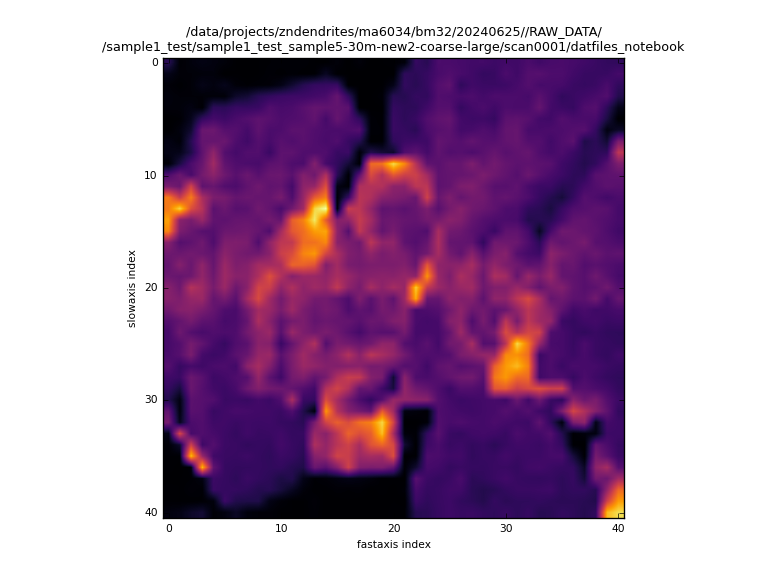

Text(0.5, 1.0, '/data/projects/zndendrites/ma6034/bm32/20240625//RAW_DATA/\n/sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001/datfiles_notebook')

In [32]:
# for 2D map 

# BLISS motors command
# amesh fastaxis ... ... nbstepfast slowaxis ... ...  nbstepslow
# mapdims = (nbstepslow+1,nbstepfast+1)
mapdims = (41,41)  # slow axis,   fast axis


# -------  data building ---------------
nbpeaks_l = np.zeros(len(listindinces))

for _k in np.arange(len(listindinces)):
    nbpeaks_l[_k]=allresults[_k][1]
nbpeaks_array= np.array(nbpeaks_l) 

nbpeaks2D = nbpeaks_array.reshape(mapdims)

# -------------visualisation ------------------
fig, ax = plt.subplots()
ax.imshow(nbpeaks2D,origin='upper')
ax.set_xlabel('fastaxis index')
ax.set_ylabel('slowaxis index')
if 'RAW_DATA' in str(datfilefolder):
    s1, s2 = str.split(str(datfilefolder), 'RAW_DATA')
    titleax = '%s/RAW_DATA/\n%s'%(s1,s2)
else:
    titleax = datfilefolder
    
def format_getimageindex(x, y):
    col = int(x + 0.5)
    row = int(y + 0.5)
    if col >= 0 and col < mapdims[1] and row >= 0 and row < mapdims[0]:
        img_idx = 0+ mapdims[1]*row+col
        return "x=%1.4f, y=%1.4f, imageid=%d" % (x, y,img_idx)
    else:
        return "x=%1.4f, y=%1.4f" % (x, y)
ax.format_coord = format_getimageindex

ax.set_title('%s'%titleax)

<IPython.core.display.Javascript object>


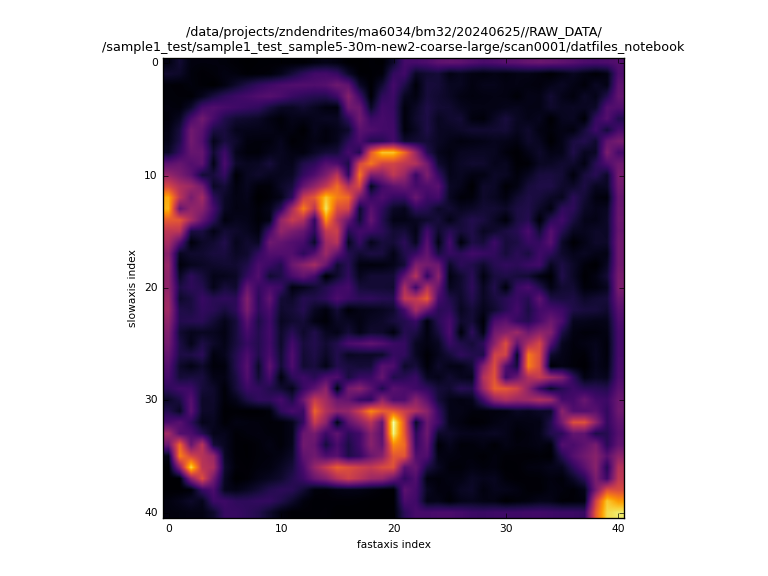

Text(0.5, 1.0, '/data/projects/zndendrites/ma6034/bm32/20240625//RAW_DATA/\n/sample1_test/sample1_test_sample5-30m-new2-coarse-large/scan0001/datfiles_notebook')

In [35]:
#  crude derivative of previous graph
nbpeaks2D = nbpeaks_array.reshape(mapdims)

import scipy.ndimage as scind

sx = scind.sobel(nbpeaks2D, axis=0, mode='constant')
sy = scind.sobel(nbpeaks2D, axis=1, mode='constant')
sob = np.hypot(sx, sy)

# -------------visualisation ------------------
fig, ax = plt.subplots()
ax.imshow(sob,origin='upper')
ax.set_xlabel('fastaxis index')
ax.set_ylabel('slowaxis index')
if 'RAW_DATA' in str(datfilefolder):
    s1, s2 = str.split(str(datfilefolder), 'RAW_DATA')
    titleax = '%s/RAW_DATA/\n%s'%(s1,s2)
else:
    titleax = datfilefolder
    
def format_getimageindex(x, y):
    col = int(x + 0.5)
    row = int(y + 0.5)
    if col >= 0 and col < mapdims[1] and row >= 0 and row < mapdims[0]:
        img_idx = 0+ mapdims[1]*row+col
        return "x=%1.4f, y=%1.4f, imageid=%d" % (x, y,img_idx)
    else:
        return "x=%1.4f, y=%1.4f" % (x, y)
ax.format_coord = format_getimageindex

ax.set_title('%s'%titleax)

In [28]:
fast_ix, slow_ix = np.argmax(nbpeaks2D)%mapdims[1], np.argmax(nbpeaks2D)//mapdims[1]
max_imageindex = slow_ix*mapdims[1]+fast_ix
max_nbpeaks = np.amax(nbpeaks2D)
print('max number of peaks is : %d'%max_nbpeaks)
print('at image : ', max_imageindex)
print('at scan position: fast_index, slow_index  :', fast_ix, slow_ix)


max number of peaks is : 264
at image :  547
at scan position: fast_index, slow_index  : 14 13


In [29]:
allpeakspos_l = -100*np.zeros((len(listindinces),int(max_nbpeaks),2))

for _k in np.arange(len(listindinces)):
    nbp = allresults[_k][1]
    if nbp > 1:
        pklist = np.array(allresults[_k][2:])
        _n = len(pklist)
        allpeakspos_l[_k][:_n]=pklist[:,:2]
allpeaksXY= np.array(allpeakspos_l) 

<IPython.core.display.Javascript object>


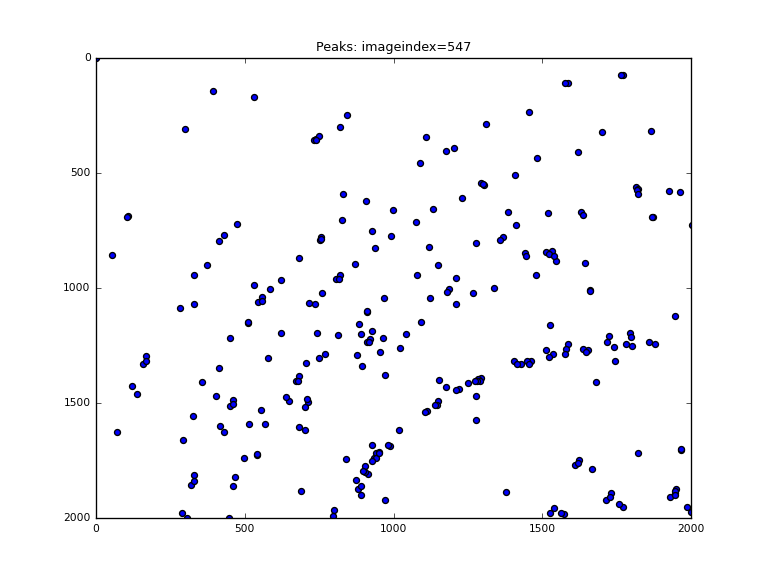

Text(0.5, 1.0, 'Peaks: imageindex=547')

In [30]:
local_index = 547
fig, ax = plt.subplots()
spots= allpeaksXY[local_index]
ax.scatter(spots[:,0], spots[:,1])
ax.set_xlim(0,2000)
ax.set_ylim(2000,0)
ax.set_title('Peaks: imageindex=%d'%listindinces[local_index])

### ipywidget Browser

<IPython.core.display.Javascript object>


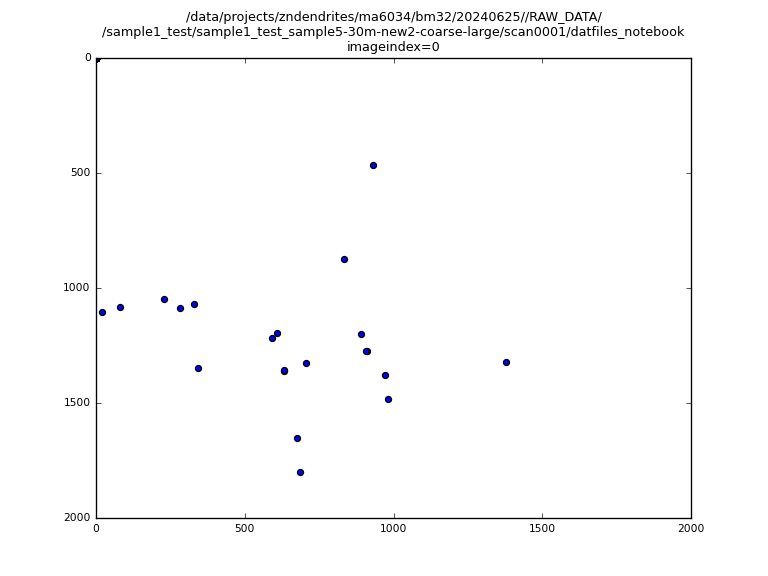

interactive(children=(IntSlider(value=0, description='imageindex', max=1679), Output()), _dom_classes=('widget…

In [31]:

from ipywidgets import interact, interactive, fixed, interact_manual
imageindex0 = 0
fig, ax = plt.subplots()
spots= allpeaksXY[imageindex0]
ax.scatter(spots[:,0], spots[:,1])
ax.set_xlim(0,2000)
ax.set_ylim(2000,0)
ax.set_title('Peaks: imageindex=%d'%listindinces[local_index])
    
def plotpeaks(imageindex=imageindex0):
    ymin, ymax = ax.get_ylim()
    xmin, xmax = ax.get_xlim()
    ax.clear()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    spots= allpeaksXY[imageindex]
    ax.scatter(spots[:,0], spots[:,1])
    if 'RAW_DATA' in str(datfilefolder):
        s1, s2 = str.split(str(datfilefolder), 'RAW_DATA')
        titleax = '%s/RAW_DATA/\n%s'%(s1,s2)
    else:
        titleax = datfilefolder
    ax.set_title('%s\nimageindex=%d'%(titleax,imageindex))

    
interactive(plotpeaks, imageindex=(0,max(listindinces)-1))